In [5]:
# imports
import os
import math
import dill
from itertools import permutations




import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LogisticRegression as logreg


import TwoPUtils
import STX3KO_analyses as stx



%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def common_rois(roi_matches,inds):
    
    
    ref =  roi_matches[inds[0]]
    ref_common_rois = []
    
    
    for i, targ_ind in enumerate(inds[1:]):
        
#         targ = roi_matches[targ_ind][inds[0]]
        if i==0:
            
            ref_common_rois = set(ref[targ_ind]['ref_inds']) 
        else: 
            ref_common_rois = ref_common_rois & set(ref[targ_ind]['ref_inds'])
        
        # find cells that are in reference match list each time
    ref_common_rois = list(ref_common_rois)

    # find matching indices
    common_roi_mapping = np.zeros([len(inds), len(ref_common_rois)])*np.nan
    common_roi_mapping[0,:]=ref_common_rois
    for i, roi in enumerate(ref_common_rois):
        for j, targ_ind in enumerate(inds[1:]):
#             print(j)
            ind = np.argwhere(ref[targ_ind]['ref_inds']==roi)[0][0]
#             print(j,roi,ind)
            common_roi_mapping[j+1,i] = ref[targ_ind]['targ_inds'][ind]

    return common_roi_mapping.astype(np.int)

def load_single_day(mouse, day = 0):

#     mouse = '4467331.2'
    pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)
    if mouse in stx.ymaze_sess_deets.KO_sessions.keys():
        
        deets = stx.ymaze_sess_deets.KO_sessions[mouse][day]
    elif mouse in stx.ymaze_sess_deets.CTRL_sessions.keys():
        deets = stx.ymaze_sess_deets.CTRL_sessions[mouse][day]
    else:
        raise Exception("invalid mouse name")


    print(deets)
    if isinstance(deets,tuple):
        with open(os.path.join(pkldir,"roi_aligner_results.pkl"),'rb') as file:
            match_inds = dill.load(file)
        
        
        common_roi_mapping = common_rois(match_inds, [d['ravel_ind'] for d in deets])
        sess_list = []
        for _deets in deets:
            _sess = stx.session.YMazeSession.from_file(
                                os.path.join(pkldir, _deets['date'], "%s_%d.pkl" % (_deets['scene'], _deets['session'])),
                                verbose=False)
            _sess.add_timeseries(licks=_sess.vr_data['lick']._values)
            _sess.add_pos_binned_trial_matrix('licks')
            _sess.novel_arm = _deets['novel']
    #             _sess_list.append(sess)
            print(_deets['date'],_deets['scene'])
            sess_list.append(_sess)


        sess = Concat_Session(sess_list,common_roi_mapping, day_inds = [0 for i in range(len(deets))], trial_mat_keys= ['F_dff', 'spks', 'F_dff_norm', 'spks_norm'])
        if mouse in ['4467332.2'] and day ==0:
            mask = sess.trial_info['sess_num_ravel']>0
            sess.trial_info['block_number'][mask] -= 1
    else:
        sess = stx.session.YMazeSession.from_file(
                                os.path.join(pkldir, deets['date'], "%s_%d.pkl" % (deets['scene'], deets['session'])),
                                verbose=False)
        sess.add_timeseries(licks=sess.vr_data['lick']._values)
        sess.add_pos_binned_trial_matrix('licks')
        sess.novel_arm = deets['novel']
        if mouse == '4467975.1' and day==0:
            sess.trial_info['block_number']+=1
        if mouse == '4467332.2' and day == 0:
            sess.trial_info['block_number']+=2
    return sess

class Concat_Session():
    
    def __init__(self,sess_list, common_roi_mapping, trial_info_keys = ['LR', 'block_number'], trial_mat_keys = ['F_dff'], 
                 timeseries_keys = [], run_place_cells = True, day_inds = None):
        attrs = self.concat(sess_list, common_roi_mapping, trial_info_keys, trial_mat_keys, 
                 timeseries_keys, run_place_cells,  day_inds)
        
        self.__dict__.update(attrs)
        trial_info_keys = []
    @staticmethod    
    def concat(_sess_list, common_roi_mapping, t_info_keys, t_mat_keys, 
                 timeseries_keys, run_place_cells,  day_inds):
        attrs = {}
        # same info
#         same_attrs = ['mouse', 'novel_arm','rzone_early', 'rzone_late']
        attrs.update({ 'mouse': _sess_list[0].mouse,
                      'novel_arm': _sess_list[0].novel_arm,
                      'rzone_early': _sess_list[0].rzone_early,
                      'rzone_late': _sess_list[0].rzone_late
                    })
        print(t_info_keys)
        
        # concat basic info 
        basic_info_attrs = ['date', 'scan', 'scan_info', 'scene', 'session', 'teleport_inds', 'trial_start_inds']
        attrs.update({k:[] for k in basic_info_attrs})

        if 'sess_num_ravel' not in t_info_keys:
            t_info_keys.append('sess_num_ravel')
        if 'sess_num' not in t_info_keys and day_inds is not None:
            t_info_keys.append('sess_num')
            
        trial_info = {k:[] for k in t_info_keys}

        trial_mat = {k:[] for k in t_mat_keys}
        trial_mat['bin_edges']=_sess_list[0].trial_matrices['bin_edges']
        trial_mat['bin_centers']=_sess_list[0].trial_matrices['bin_centers']

        timeseries = {k:[] for k in timeseries_keys}

        if run_place_cells:
            place_cells = {-1:{'masks':[], 'SI': [], 'p':[]}, 1: {'masks':[], 'SI': [], 'p':[]}}

        last_block = 0
        for ind, _sess in enumerate(_sess_list):

            for k in basic_info_attrs:
                attrs[k].append(getattr(_sess,k))

            for k in t_info_keys:

                if k == 'sess_num_ravel' :
                    trial_info[k].append(np.zeros([_sess.trial_info['LR'].shape[0],])+ind)
                elif k == 'sess_num' and day_inds is not None:
                    trial_info[k].append(np.zeros([_sess.trial_info['LR'].shape[0],])+day_inds[ind])
            
                elif k == 'block_number' and day_inds is not None and ind>0:
                    if _sess.trial_info[k][0]==0 and day_inds[ind-1]==day_inds[ind]:
                        trial_info[k].append(_sess.trial_info[k] + _sess_list[ind-1].trial_info[k][-1] +1)
                    else:
                        trial_info[k].append(_sess.trial_info[k])
                else:
                    trial_info[k].append(_sess.trial_info[k])

            for k in t_mat_keys:
                trial_mat[k].append(_sess.trial_matrices[k][:,:,common_roi_mapping[ind,:]])

            for k in timeseries_keys:
                timeseries[k].append(_sess.timeseries[k][:,:,common_roi_mapping[ind,:]])


            if run_place_cells:
                for lr, _lr in [[-1,'left'], [1, 'right']]:
                    for k in ['masks', 'SI', 'p']:
                        place_cells[lr][k].append(_sess.place_cell_info[_lr][k][common_roi_mapping[ind,:]])

        print(t_info_keys)
        for k in t_info_keys:
            print(k)
            trial_info[k]= np.concatenate(trial_info[k])
        attrs['trial_info']=trial_info

        for k in t_mat_keys:
            trial_mat[k] = np.concatenate(trial_mat[k],axis=0)
        attrs['trial_matrices']=trial_mat
        
        if run_place_cells:
            for lr in [-1, 1]:
                    for k in ['masks', 'SI', 'p']:
                        place_cells[lr][k] = np.array(place_cells[lr][k])
        attrs['place_cell_info'] = place_cells
        
        return attrs
    
def single_mouse_concat_sessions(mouse,date_inds=None):
    pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)

    with open(os.path.join(pkldir,"roi_aligner_results.pkl"),'rb') as file:
        match_inds = dill.load(file)

    if mouse in stx.ymaze_sess_deets.KO_sessions.keys():  
        sessions_deets = stx.ymaze_sess_deets.KO_sessions[mouse]
    elif mouse in stx.ymaze_sess_deets.CTRL_sessions.keys():
        sessions_deets = stx.ymaze_sess_deets.CTRL_sessions[mouse]
    else:
        print( "mouse ID typo")
        
    
    if date_inds is None:
        date_inds = np.arange(len(sessions_deets)).tolist()
    
    date_inds_ravel = []
    roi_inds = []
    sess_list = []
    for date_ind in date_inds:
        deets = sessions_deets[date_ind]
        if isinstance(deets, tuple):
            _sess_list = []
            for _deets in deets:
                sess = stx.session.YMazeSession.from_file(
                                    os.path.join(pkldir, _deets['date'], "%s_%d.pkl" % (_deets['scene'], _deets['session'])),
                                    verbose=False)
                sess.add_timeseries(licks=sess.vr_data['lick']._values)
                sess.add_pos_binned_trial_matrix('licks')
                sess.novel_arm = _deets['novel']
    #             _sess_list.append(sess)
                print(_deets['date'],_deets['scene'])
                sess_list.append(sess)
                date_inds_ravel.append(date_ind)
                roi_inds.append(_deets['ravel_ind'])
        else:
            sess = stx.session.YMazeSession.from_file(
                                    os.path.join(pkldir, deets['date'], "%s_%d.pkl" % (deets['scene'], deets['session'])),
                                    verbose=False)
            sess.add_timeseries(licks=sess.vr_data['lick']._values)
            sess.add_pos_binned_trial_matrix('licks')
            sess.novel_arm = deets['novel']
            sess_list.append(sess)
            date_inds_ravel.append(date_ind)
            roi_inds.append(deets['ravel_ind'])
            print(deets['date'],deets['scene'])


    common_roi_mapping = common_rois(match_inds, roi_inds)
    concat_sess = Concat_Session(sess_list,common_roi_mapping, day_inds = date_inds_ravel, trial_mat_keys=['F_dff', 'F_dff_norm', 'spks', 'spks_norm'])
    return concat_sess
        

$$P(X \vec Y) \propto P(\vec Y | X) P(X)  = P(X) \prod_{i=0}^{M} P(Y_i| X) \\
P(Y_i|X) \sim Gamma(Y_i; k_{i,x}) \\
Gamma(y; k) = \frac{1}{\Gamma(k)} y^{k-1} e ^{-x} $$

$k$ is the mean dF/F at that position \\

assume $P(X)$ is uniform

In [7]:
gamma = lambda x,kappa:  1/sp.special.gamma(kappa)* np.exp(-x)*np.power(x,kappa-1)
poiss = lambda k,lam:  1/sp.special.gamma(k)* np.exp(-lam)*np.power(lam,k)

def logsumexp(x,axis=-1):
    c = x.max(axis = axis, keepdims=True) + 1E-5
    return c + np.log(np.sum(np.exp(x - c ),axis=axis, keepdims=True))

In [8]:
# within day models

def baseline_crossval(_sess, n_cells = -1, poisson = False):
    # assuming uniform prior over bins
    
    trial_mat = np.copy(_sess.trial_matrices['spks'][_sess.trial_info['block_number']<5,:,:])*10
    trial_mat -= np.amin(trial_mat,axis=-1,keepdims=True)
    trial_mat += 1E-3

    # select cells
    if n_cells ==-1:
#         print('all_cells')
        pass
    else:
        rng = np.random.default_rng()
        trial_mat = trial_mat[:,:,rng.permutation(trial_mat.shape[-1])[:n_cells]]
    
    posterior = np.zeros([trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[1]])
    for trial in range(trial_mat.shape[0]):
        
        mask = np.zeros((trial_mat.shape[0],))<1
        mask[trial] = False
        
        trial_mat_mean = np.nanmean(trial_mat[mask,:,:],axis=0)
        
        y = np.copy(trial_mat[trial,:,:])
        y[np.isnan(y)]=1E-3
        log_likelihood = 0
        for cell in range(trial_mat.shape[-1]):
            if poiss:
                log_likelihood += np.log(poiss(y[:,cell:cell+1], trial_mat_mean[:,cell:cell+1].T)+1E-3)
            else:
                log_likelihood += np.log(gamma(y[:,cell:cell+1], trial_mat_mean[:,cell:cell+1].T)+1E-3)
        
        posterior[trial,:,:] = np.exp(log_likelihood - logsumexp(log_likelihood))
        

    
    return posterior


def test(_y, trial_mat_mean, poisson=False):
    log_likelihood = 0
    for cell in range(trial_mat_mean.shape[-1]):
        yc, tmm = _y[:,cell], trial_mat_mean[:,cell]
        if poisson:
            log_likelihood += np.log(poiss(yc[:,np.newaxis], tmm[np.newaxis,:])+1E-3)
        else:
            log_likelihood += np.log(gamma(yc[:,np.newaxis], tmm[np.newaxis,:])+1E-3)
    return np.exp(log_likelihood - logsumexp(log_likelihood))
        
def train_baseline_test_lastblock(_sess, n_cells = -1, poisson = False):
    # assuming uniform prior over bins
    baseline = _sess.trial_info['block_number']<5
    
    fam_test = (_sess.trial_info['block_number']==5)*(_sess.trial_info['LR']==-1*_sess.novel_arm)
    nov_test = (_sess.trial_info['block_number']==5)*(_sess.trial_info['LR']==_sess.novel_arm)
    
    trial_mat = np.copy(_sess.trial_matrices['spks'])*10
    trial_mat -= np.amin(trial_mat,axis=-1,keepdims=True)
    trial_mat += 1E-3

    
    # select cellsScreenshot from 2021-05-17 21-32-35
    if n_cells ==-1:
#         print('all_cells')
        pass
    else:
        rng = np.random.default_rng()
        trial_mat = trial_mat[:,:,rng.permutation(trial_mat.shape[-1])[:n_cells]]
    trial_mat_mean = np.nanmean(trial_mat[baseline,:,:],axis=0)
    
    fam_post, nov_post = [], []
    for trial in range(trial_mat.shape[0]):
        if fam_test[trial]:
            fam_post.append(test(np.copy(trial_mat[trial,:,:]), trial_mat_mean, poisson=poisson))
        elif nov_test[trial]:
            nov_post.append(test(np.copy(trial_mat[trial,:,:]), trial_mat_mean, poisson=poisson))
        else:
            pass
    return np.array(fam_post), np.array(nov_post)
        

In [15]:
figdir = "/mnt/BigDisk/YMazeResults/neural/naive_bayes"
os.makedirs(figdir,exist_ok=True)

In [9]:
mouse = '4467975.5'
sess = load_single_day(mouse,day=0)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}


In [10]:
# post = baseline_crossval(sess,poisson=True)
fam_post, nov_post = train_baseline_test_lastblock(sess,poisson=True)


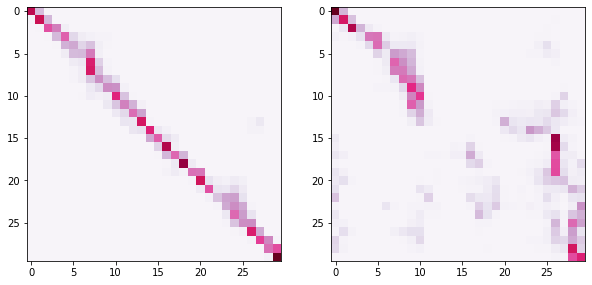

In [11]:
# fig,ax = plt.subplots()
# ax.imshow(post.mean(axis=0),cmap='PuRd')

fig,ax = plt.subplots(1,2,figsize=[10,5])
ax[0].imshow(fam_post.mean(axis=0),cmap='PuRd')
ax[1].imshow(nov_post.mean(axis=0),cmap='PuRd')

### Decoding of position in baseline trials on Day 0

In [12]:
ko_baseline_cv_post = {mouse:baseline_crossval(load_single_day(mouse,day=0)) for mouse in stx.ymaze_sess_deets.KO_sessions.keys()}
ctrl_baseline_cv_post = {mouse:baseline_crossval(load_single_day(mouse,day=0)) for mouse in stx.ymaze_sess_deets.CTRL_sessions.keys()}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}


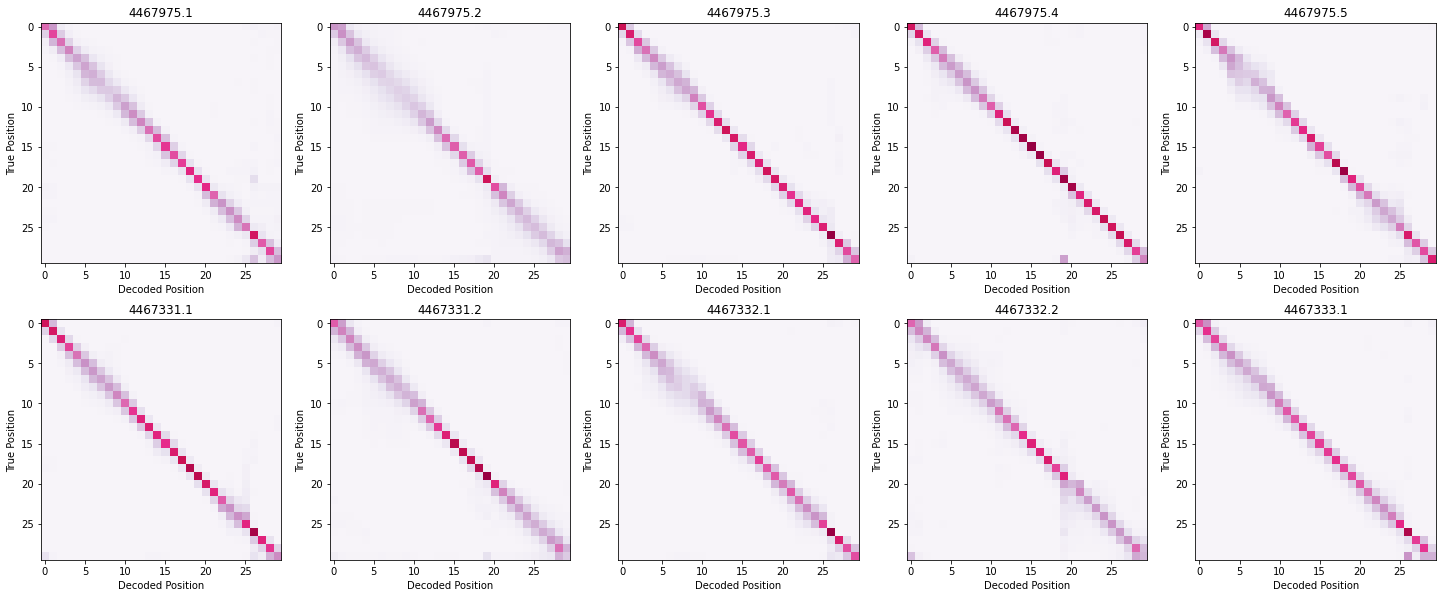

In [16]:
fig, ax = plt.subplots(2,5,figsize= [25, 10 ])

for i,(mouse,post) in enumerate(ko_baseline_cv_post.items()):
    ax[0,i].imshow(post.mean(axis=0),cmap='PuRd',vmin=0,vmax=1)
    ax[0,i].set_xlabel('Decoded Position')
    ax[0,i].set_ylabel('True Position')
    ax[0,i].set_title(mouse)
    
    
for i,(mouse,post) in enumerate(ctrl_baseline_cv_post.items()):
    ax[1,i].imshow(post.mean(axis=0),cmap='PuRd',vmin=0,vmax=1)
    ax[1,i].set_xlabel('Decoded Position')
    ax[1,i].set_ylabel('True Position')
    ax[1,i].set_title(mouse)

fig.savefig(os.path.join(figdir,"day0_crossval_decoding.pdf"))

In [19]:
# decoding error as a function of position
def err_metrics(post):
    err = np.zeros([*post.shape[:2]])*np.nan
    unc = np.zeros([*post.shape[:2]])*np.nan
    true_pos = np.arange(0,post.shape[1])
    for trial in range(post.shape[0]):
        decode_pos = np.argmax(post[trial,:,:],axis=-1)
        err[trial,:] = np.abs(decode_pos-true_pos)
        unc[trial,:] = sp.stats.entropy(post[trial,:,:],axis=-1)
    return err, unc
    
    

# decoding uncertainy as a function of position
# fig, ax = plt.subplots(2,5,figsize= [25, 10])
# for i,(mouse,post) in enumerate(ko_baseline_cv_post.items()):
#     err, unc = err_metrics(post)
#     ax[0,i].plot(err.T,color = 'red')
# for i,(mouse,post) in enumerate(ctrl_baseline_cv_post.items()):
#     err, unc = err_metrics(post)
#     ax[1,i].plot(err.T,color = 'black')
    
# fig, ax = plt.subplots(2,5,figsize= [25, 10])
# for i,(mouse,post) in enumerate(ko_baseline_cv_post.items()):
#     err, unc = err_metrics(post)
#     ax[0,i].plot(unc.T,color = 'red')
# for i,(mouse,post) in enumerate(ctrl_baseline_cv_post.items()):
#     err, unc = err_metrics(post)
#     ax[1,i].plot(unc.T,color = 'black')
    
#     ax[0,i].imshow(post.mean(axis=0),cmap='PuRd',vmin=0,vmax=1)    
# for i,(mouse,post) in enumerate(ctrl_baseline_cv_post.items()):
#     ax[1,i].imshow(post.mean(axis=0),cmap='PuRd',vmin=0,vmax=1)

In [17]:
# sub sample cells to match N

# for n_cells in [8, 16, 32, 64, 128, 256, ]
def run_ncells_baseline_crossval(mice, day = 0):
    results = {}
    for mouse in mice:
        print('mouse', mouse)
        results[mouse]={}
        sess = load_single_day(mouse,day=day)
        for n_cells in [2**n for n in range(3,9)]:
            print('n cells', n_cells)
            post = []
            for rep in range(30):
                post.append(baseline_crossval(sess,n_cells=n_cells))
            post = np.concatenate(post,axis=0)
            results[mouse][n_cells]=post
    return results

ko_ncells_crossval = run_ncells_baseline_crossval(stx.ymaze_sess_deets.KO_sessions.keys())
ctrl_ncells_crossval = run_ncells_baseline_crossval(stx.ymaze_sess_deets.CTRL_sessions.keys())

mouse 4467975.1
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467975.2
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467975.3
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467975.4
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel': 1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467975.5
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467331.1
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467

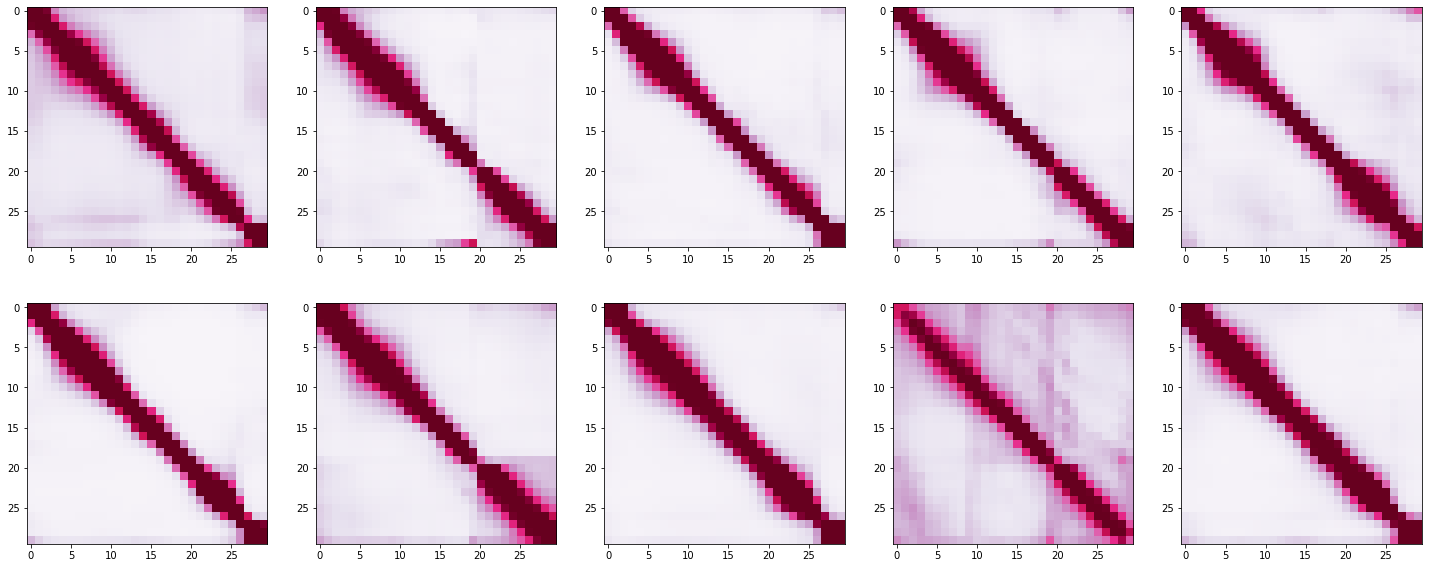

In [12]:
fig, ax = plt.subplots(2,5,figsize= [25, 10 ])

for i,(mouse,post) in enumerate(ko_ncells_crossval.items()):
    ax[0,i].imshow(post[256].mean(axis=0),cmap='PuRd',vmin=0,vmax=.1)
    
for i,(mouse,post) in enumerate(ctrl_ncells_crossval.items()):
    ax[1,i].imshow(post[256].mean(axis=0),cmap='PuRd',vmin=0,vmax=.1)

Text(0, 0.5, 'decoding entropy')

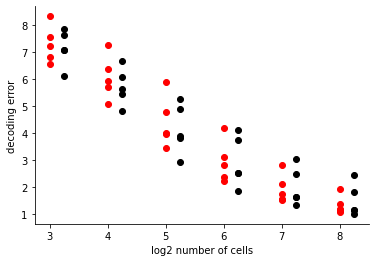

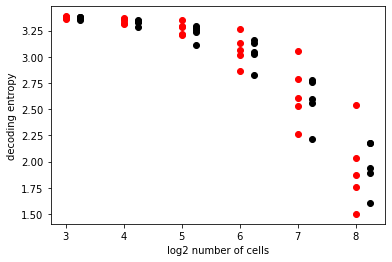

In [20]:
# plot err as a function of number of cells for different models
fig,ax = plt.subplots()
for i, n_cells in enumerate(ko_ncells_crossval['4467975.1'].keys()):
    _err = []
    for mouse in ko_ncells_crossval.keys():
        base_err, base_unc = err_metrics(ko_ncells_crossval[mouse][n_cells])
        _err.append(base_err.mean())
    ax.scatter(np.log2(n_cells*np.ones([5,])),_err,color='red')
    
    _err = []
    for mouse in ctrl_ncells_crossval.keys():
        base_err, base_unc = err_metrics(ctrl_ncells_crossval[mouse][n_cells])
        _err.append(base_err.mean())
    ax.scatter(np.log2(n_cells*np.ones([5,]))+.25,_err,color='black')
ax.set_xlabel('log2 number of cells')
ax.set_ylabel('decoding error')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir,'day0_ncells_baseline_crossval_error.pdf'))

# scatter()
fig,ax = plt.subplots()
for i, n_cells in enumerate(ko_ncells_crossval['4467975.1'].keys()):
    _err = []
    for mouse in ko_ncells_crossval.keys():
        base_err, base_unc = err_metrics(ko_ncells_crossval[mouse][n_cells])
        _err.append(base_unc.mean())
    ax.scatter(np.log2(n_cells*np.ones([5,])),_err,color='red')
    
    _err = []
    for mouse in ctrl_ncells_crossval.keys():
        base_err, base_unc = err_metrics(ctrl_ncells_crossval[mouse][n_cells])
        _err.append(base_unc.mean())
    ax.scatter(np.log2(n_cells*np.ones([5,]))+.25,_err,color='black')
ax.set_xlabel('log2 number of cells')
ax.set_ylabel('decoding entropy')

In [26]:
def run_test_lastblock(mice, day = 0):
    results = {}
    for mouse in mice:
        
        sess = load_single_day(mouse, day = day)
        fam_post, nov_post = train_baseline_test_lastblock(sess, n_cells = -1, poisson=True)
        results[mouse]={'fam':fam_post, 'nov':nov_post}
    return results

ko_test_lastblock = run_test_lastblock(stx.ymaze_sess_deets.KO_sessions.keys())
ctrl_test_lastblock = run_test_lastblock(stx.ymaze_sess_deets.CTRL_sessions.keys())

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1

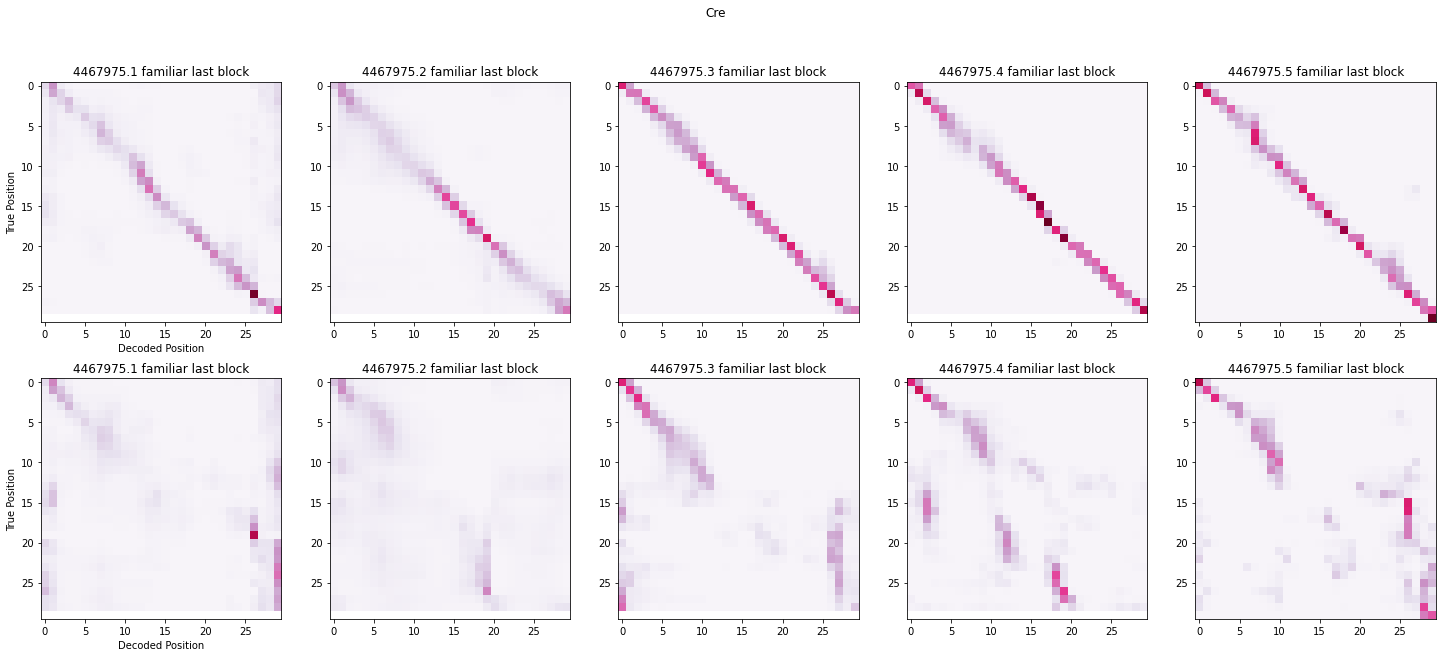

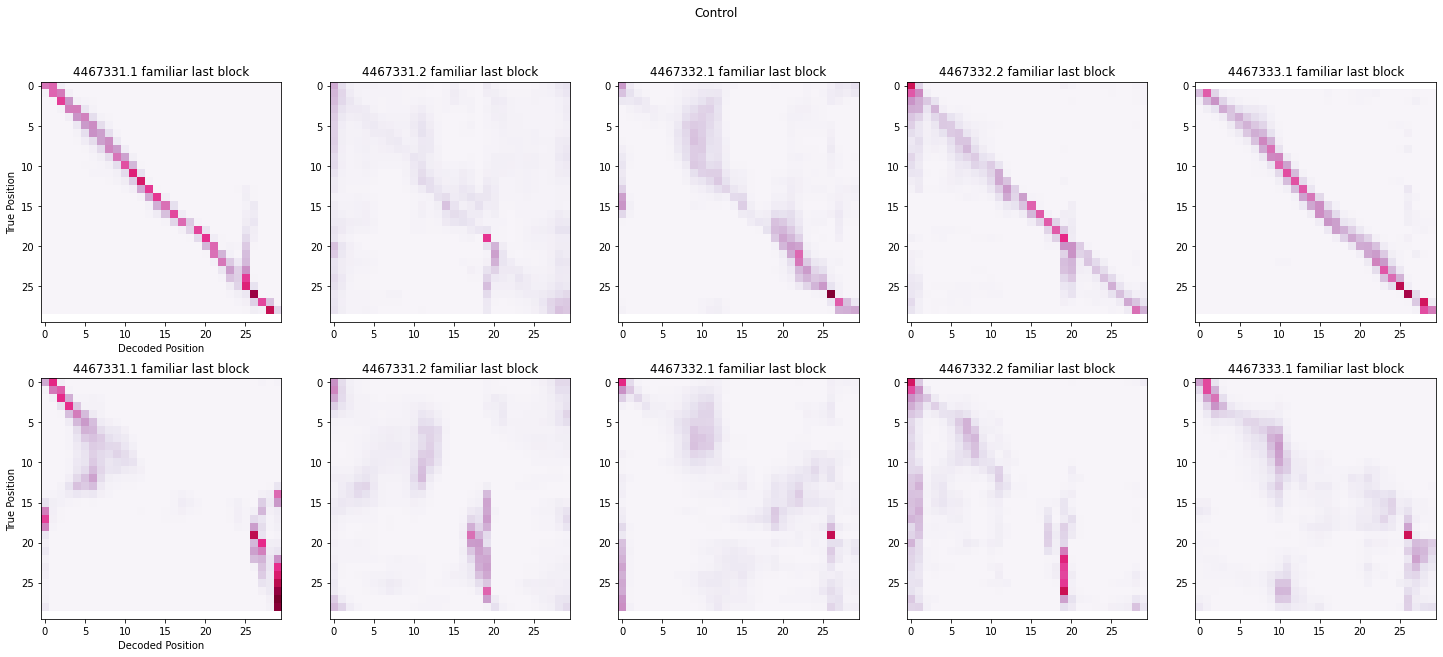

In [29]:
fig, ax = plt.subplots(2,5,figsize= [25, 10 ])
fig.suptitle('Cre')

for i,(mouse,post) in enumerate(ko_test_lastblock.items()):
#     print(post)
    ax[0,i].imshow(post['fam'].mean(axis=0),cmap='PuRd',vmin=0,vmax=1)
    ax[0,i].set_title("%s familiar last block" % mouse)
ax[0,0].set_xlabel('Decoded Position')
ax[0,0].set_ylabel('True Position')
for i,(mouse,post) in enumerate(ko_test_lastblock.items()):
    ax[1,i].imshow(post['nov'].mean(axis=0),cmap='PuRd',vmin=0,vmax=1)
    ax[1,i].set_title("%s familiar last block" % mouse)
ax[1,0].set_xlabel('Decoded Position')
ax[1,0].set_ylabel('True Position')
    
    
fig.savefig(os.path.join(figdir, "KO_day0_train_baseline_test_lastblock.pdf"))

fig, ax = plt.subplots(2,5,figsize= [25, 10 ])
fig.suptitle('Control')

for i,(mouse,post) in enumerate(ctrl_test_lastblock.items()):
    ax[0,i].imshow(post['fam'].mean(axis=0),cmap='PuRd',vmin=0,vmax=1)
    ax[0,i].set_title("%s familiar last block" % mouse)
ax[0,0].set_xlabel('Decoded Position')
ax[0,0].set_ylabel('True Position')
for i,(mouse,post) in enumerate(ctrl_test_lastblock.items()):
    ax[1,i].imshow(post['nov'].mean(axis=0),cmap='PuRd',vmin=0,vmax=1)
    ax[1,i].set_title("%s familiar last block" % mouse)
ax[1,0].set_xlabel('Decoded Position')
ax[1,0].set_ylabel('True Position')

fig.savefig(os.path.join(figdir, "CTRL_day0_train_baseline_test_lastblock.pdf"))

-1.775592090748118 0.07580017458236125
-0.3133397807202561 0.7540225300620748
-0.1044465935734187 0.9168149485280885


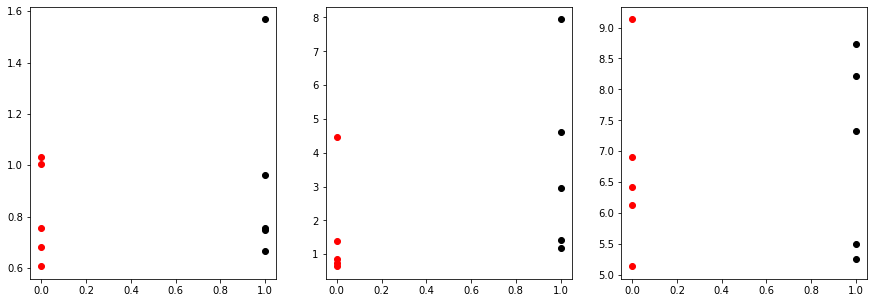

In [35]:
fig, ax = plt.subplots(1,3,figsize= [15, 5])

base_err_list, fam_err_list, nov_err_list = [],[], []
for mouse in ko_test_lastblock.keys():
    base_err, base_unc = err_metrics(ko_baseline_cv_post[mouse])
    famtest_err, famtest_unc = err_metrics(ko_test_lastblock[mouse]['fam'])
    novtest_err, novtest_unc = err_metrics(ko_test_lastblock[mouse]['nov'])
    base_err_list.append(np.mean(base_err.ravel()))
    fam_err_list.append(np.mean(famtest_err.ravel()))
    nov_err_list.append(np.mean(novtest_err.ravel()))
    
ko_base_err_list = np.array(base_err_list)
ko_fam_err_list = np.array(fam_err_list)
ko_nov_err_list = np.array(nov_err_list)
ax[0].scatter(np.zeros([5,]), ko_base_err_list, color='red')
ax[1].scatter(np.zeros([5,]), ko_fam_err_list, color='red')
ax[2].scatter(np.zeros([5,]), ko_nov_err_list, color='red')

    
base_err_list, fam_err_list, nov_err_list = [],[], []
for mouse in ctrl_test_lastblock.keys():
    base_err, base_unc = err_metrics(ctrl_baseline_cv_post[mouse])
    famtest_err, famtest_unc = err_metrics(ctrl_test_lastblock[mouse]['fam'])
    novtest_err, novtest_unc = err_metrics(ctrl_test_lastblock[mouse]['nov'])
    base_err_list.append(np.mean(base_err.ravel()))
    fam_err_list.append(np.mean(famtest_err.ravel()))
    nov_err_list.append(np.mean(novtest_err.ravel()))

ctrl_base_err_list = np.array(base_err_list)
ctrl_fam_err_list = np.array(fam_err_list)
ctrl_nov_err_list = np.array(nov_err_list)
ax[0].scatter(np.ones([5,]), ctrl_base_err_list, color='black')
ax[1].scatter(np.ones([5,]), ctrl_fam_err_list, color='black')
ax[2].scatter(np.ones([5,]), ctrl_nov_err_list, color='black')


t,p = sp.stats.ranksums((ko_fam_err_list-ko_base_err_list)/ko_base_err_list,(ctrl_fam_err_list-ctrl_base_err_list)/ctrl_base_err_list)
t,p = sp.stats.ranksums(ko_fam_err_list,ctrl_fam_err_list)
print(t,p)
t,p = sp.stats.ranksums(ko_nov_err_list,ctrl_nov_err_list)
print(t,p)
t,p = sp.stats.ranksums(ko_base_err_list,ctrl_base_err_list)
print(t,p)


In [36]:
def run_ncells_test_lastblock(mice, day = 0):
    results = {}
    for mouse in mice:
        print('mouse', mouse)
        results[mouse]={}
        sess = load_single_day(mouse,day=day)
        for n_cells in [2**n for n in range(3,9)]:
            print('n cells', n_cells)
            fam_post, nov_post = [],[]
            for rep in range(30):
                _fam, _nov = train_baseline_test_lastblock(sess, n_cells = n_cells, poisson=True)
                fam_post.append(_fam)
                nov_post.append(_nov)
            fam_post = np.concatenate(fam_post,axis=0)
            nov_post = np.concatenate(nov_post,axis=0)
            results[mouse][n_cells]={'fam':fam_post,'nov':nov_post}
    return results

ko_ncells_crossval = run_ncells_test_lastblock(stx.ymaze_sess_deets.KO_sessions.keys())
ctrl_ncells_crossval = run_ncells_test_lastblock(stx.ymaze_sess_deets.CTRL_sessions.keys())

mouse 4467975.1
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467975.2
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467975.3
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467975.4
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel': 1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467975.5
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467331.1
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467

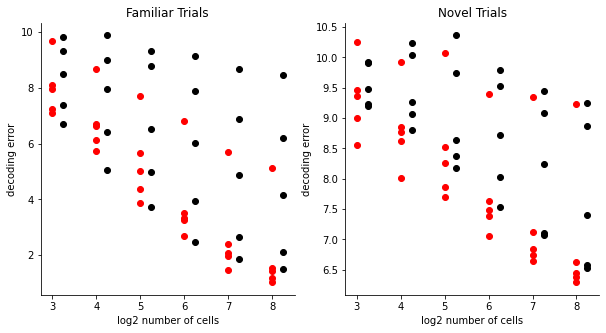

In [37]:
# plot err as a function of number of cells for different models
fig,ax = plt.subplots(1,2,figsize=[10,5])
for i, n_cells in enumerate(ko_ncells_crossval['4467975.1'].keys()):
    _err = []
    for mouse in ko_ncells_crossval.keys():
        base_err, base_unc = err_metrics(ko_ncells_crossval[mouse][n_cells]['fam'])
        _err.append(base_err.mean())
    ax[0].scatter(np.log2(n_cells*np.ones([5,])),_err,color='red')
    
    _err = []
    for mouse in ko_ncells_crossval.keys():
        base_err, base_unc = err_metrics(ko_ncells_crossval[mouse][n_cells]['nov'])
        _err.append(base_err.mean())
    ax[1].scatter(np.log2(n_cells*np.ones([5,])),_err,color='red')
    
    _err = []
    for mouse in ctrl_ncells_crossval.keys():
        base_err, base_unc = err_metrics(ctrl_ncells_crossval[mouse][n_cells]['fam'])
        _err.append(base_err.mean())
    ax[0].scatter(np.log2(n_cells*np.ones([5,]))+.25,_err,color='black')
    
    _err = []
    for mouse in ctrl_ncells_crossval.keys():
        base_err, base_unc = err_metrics(ctrl_ncells_crossval[mouse][n_cells]['nov'])
        _err.append(base_err.mean())
    ax[1].scatter(np.log2(n_cells*np.ones([5,]))+.25,_err,color='black')
    
    
    
ax[0].set_xlabel('log2 number of cells')
ax[0].set_ylabel('decoding error')
ax[0].set_title('Familiar Trials')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)


ax[1].set_xlabel('log2 number of cells')
ax[1].set_ylabel('decoding error')
ax[1].set_title('Novel Trials')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,'day0_ncells_lastblock_error.pdf'))

In [19]:
# cross validated novel arm decoding

## Across day models

In [38]:
# 

def train_oneday_test_multiday(_concat_sess, train_day, test_days, n_cells = -1, poisson = True):
    # assuming uniform prior over bins
    
    #ensure common rois
    train_mask = (_concat_sess.trial_info['sess_num']==train_day)
    fam_train = (_concat_sess.trial_info['sess_num']==train_day)*(_concat_sess.trial_info['LR']==-1*_concat_sess.novel_arm)
    nov_train = (_concat_sess.trial_info['sess_num']==train_day)*(_concat_sess.trial_info['LR']==_concat_sess.novel_arm)
    
    trial_mat = np.copy(_concat_sess.trial_matrices['spks'])*10
    trial_mat -= np.amin(trial_mat,axis=-1,keepdims=True)
    trial_mat += 1E-3

    
    # select cells
    if n_cells ==-1:
        pass
    else:
        rng = np.random.default_rng()
        trial_mat = trial_mat[:,:,rng.permutation(trial_mat.shape[-1])[:n_cells]]
    
    fam_mean = np.nanmean(trial_mat[fam_train,:,:],axis=0)
    nov_mean = np.nanmean(trial_mat[nov_train,:,:],axis=0)
    
    fam_train_post = np.zeros([trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[1]])*np.nan
    nov_train_post = np.zeros([trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[1]])*np.nan
    for trial in range(trial_mat.shape[0]):
        
        if not train_mask[trial]:
            fam_train_post[trial, :, :] = test(np.copy(trial_mat[trial, :, :]), fam_mean, poisson=poisson)
            nov_train_post[trial, :, :] = test(np.copy(trial_mat[trial, :, :]), nov_mean, poisson=poisson)
    return fam_train_post, nov_train_post
        
        
#     fam_post, nov_post = [], []
#     for trial in range(trial_mat.shape[0]):
#         if fam_test[trial]:
#             fam_post.append(test(np.copy(trial_mat[trial,:,:]), trial_mat_mean, poisson=poisson))
#         elif nov_test[trial]:
#             nov_post.append(test(np.copy(trial_mat[trial,:,:]), trial_mat_mean, poisson=poisson))
#         else:
#             pass
#     return np.array(fam_post), np.array(nov_post)

In [39]:
# days 1-6
def run_mice_multiday(mice, days = [i for i in range(6)]):
    results = {}
    for mouse in mice:
        print(mouse)
        
        concat_sess = single_mouse_concat_sessions(mouse,date_inds=days)
        fam_train, nov_train = [],[]
        for train_ind in list(days):
            print('train ind', train_ind)
            _fam_train, _nov_train = train_oneday_test_multiday(concat_sess, days[train_ind],[ind for ind in days if ind != train_ind], n_cells = -1, poisson = True)
            fam_train.append(_fam_train)
            nov_train.append(_nov_train)
        results[mouse] = {'fam_train': np.array(fam_train), 
                          'nov_train': np.array(nov_train), 
                          'sess_num': concat_sess.trial_info['sess_num'], 
                          'novel_trials': concat_sess.trial_info['LR']==concat_sess.novel_arm,
                          'fam_trials': concat_sess.trial_info['LR']==-1*concat_sess.novel_arm}
    return results
            


ko_multiday_results = run_mice_multiday(stx.ymaze_sess_deets.KO_sessions.keys())
ctrl_multiday_results = run_mice_multiday(stx.ymaze_sess_deets.CTRL_sessions.keys())

# look for shifts towards the reward for Cre vs Control

4467975.1


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
LR
block_number
sess_num_ravel
sess_num
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5
4467975.2
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
LR
block_number
sess_num_ravel
sess_num
train ind 0
train ind 1
train ind 2
train ind 3
train ind 4
train ind 5
4467975.3
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
LR
block_number
sess_num_ravel
sess_

In [ ]:
print(ko_multiday_results['4467975.1']['fam_train'].shape)

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


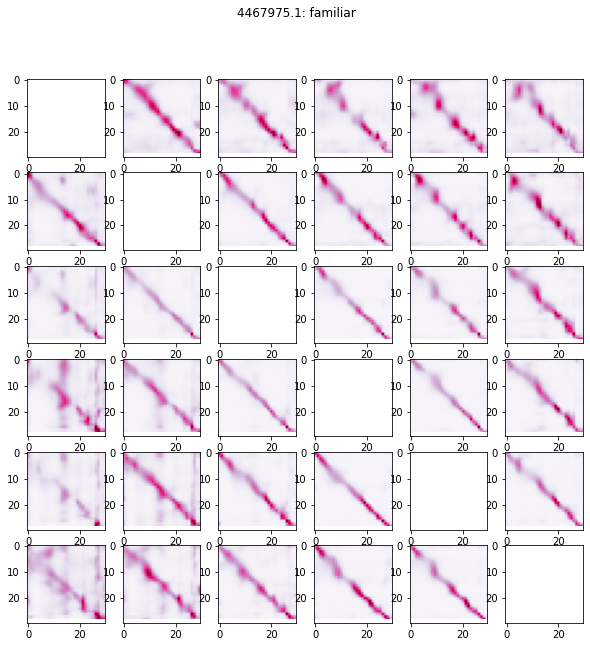

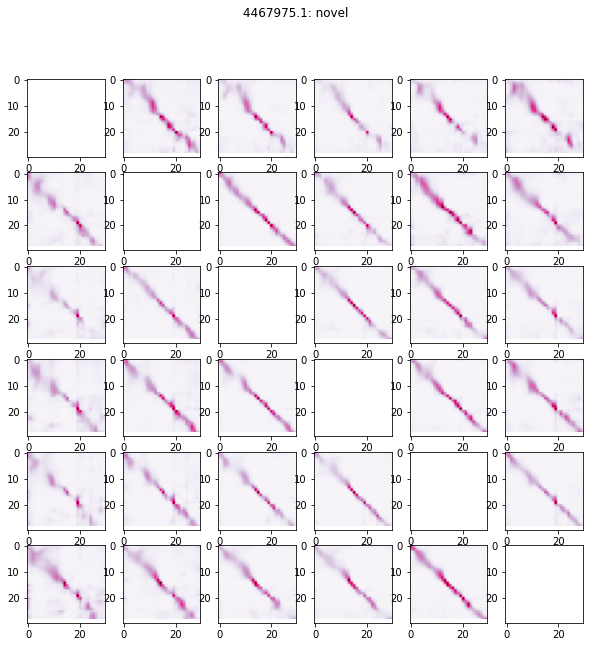

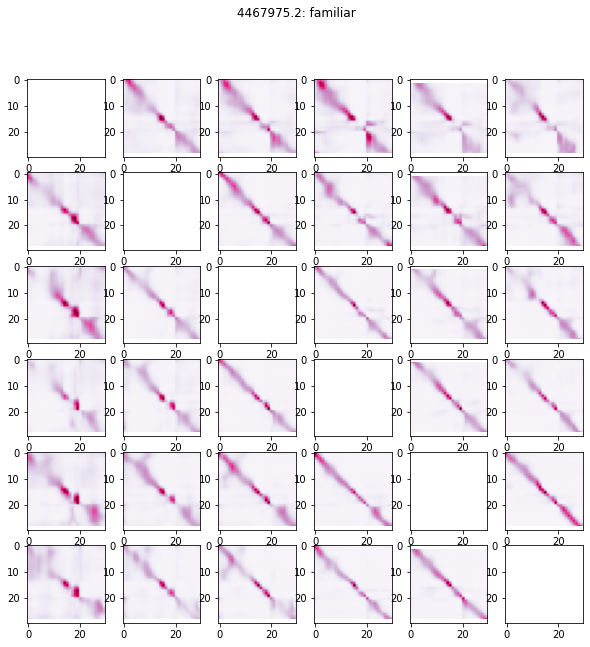

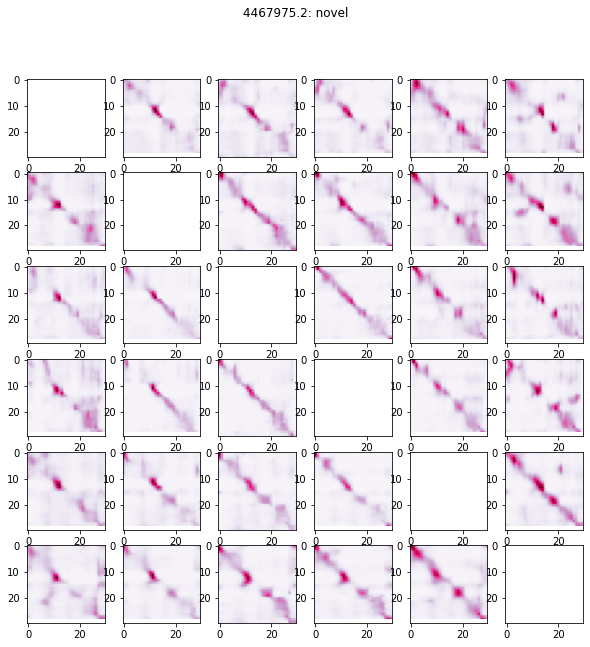

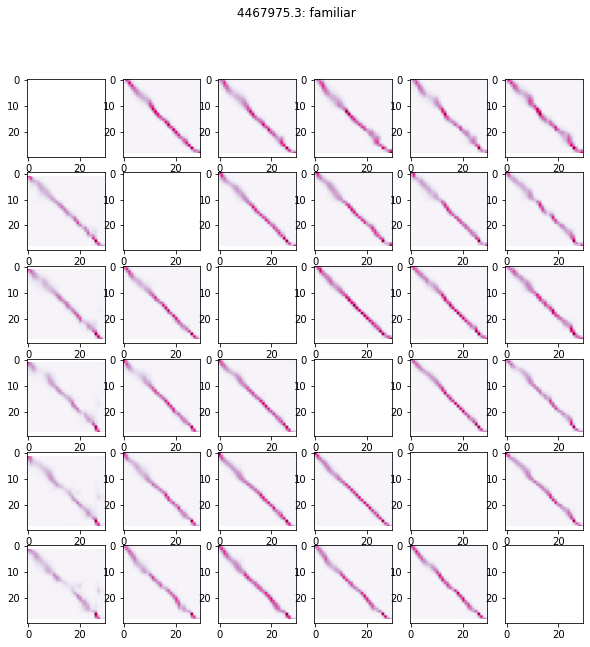

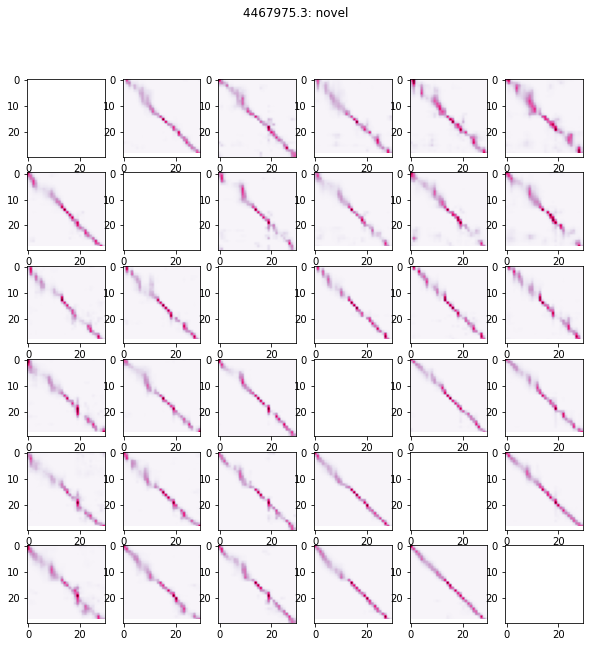

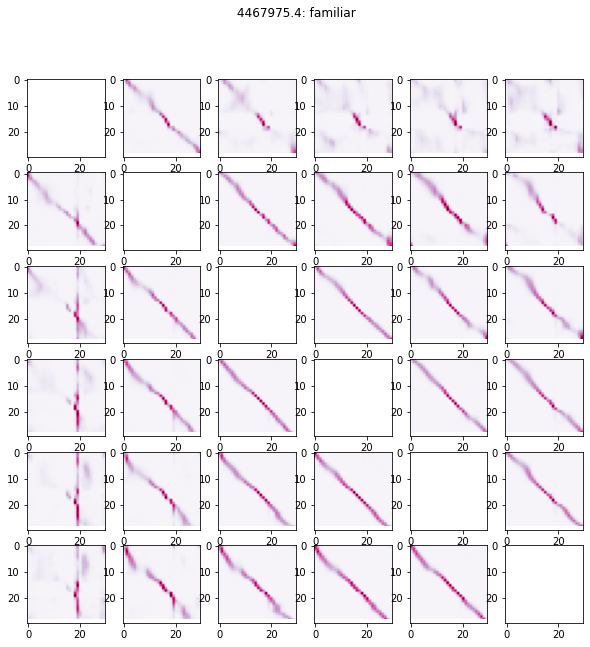

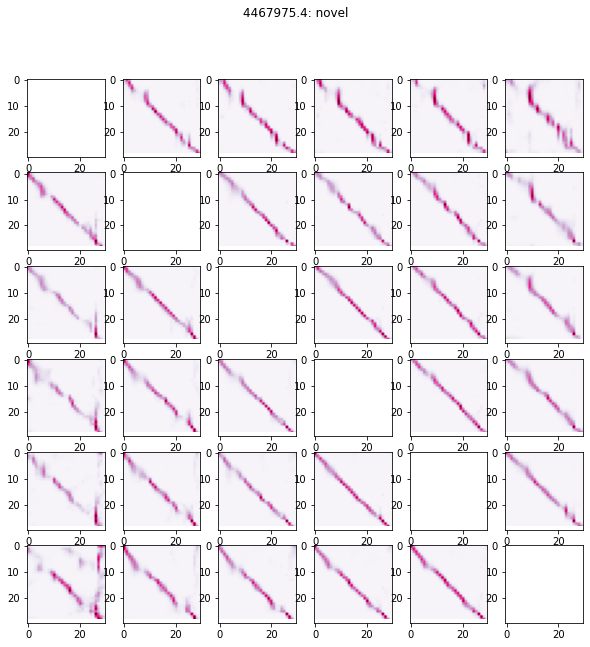

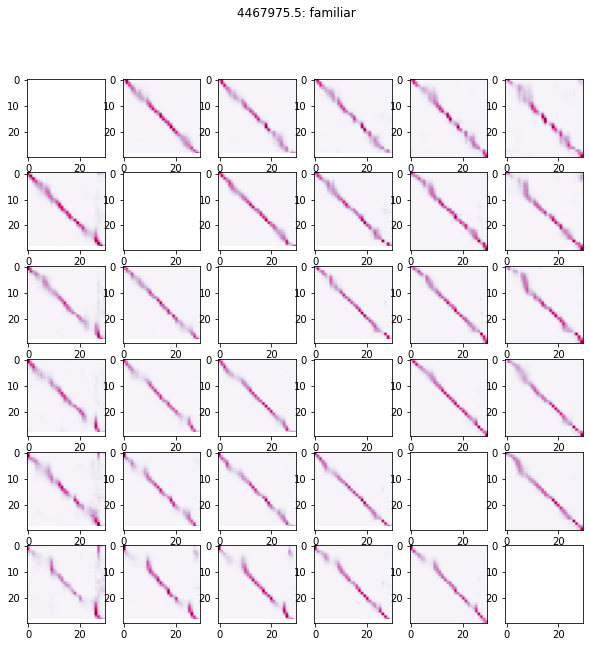

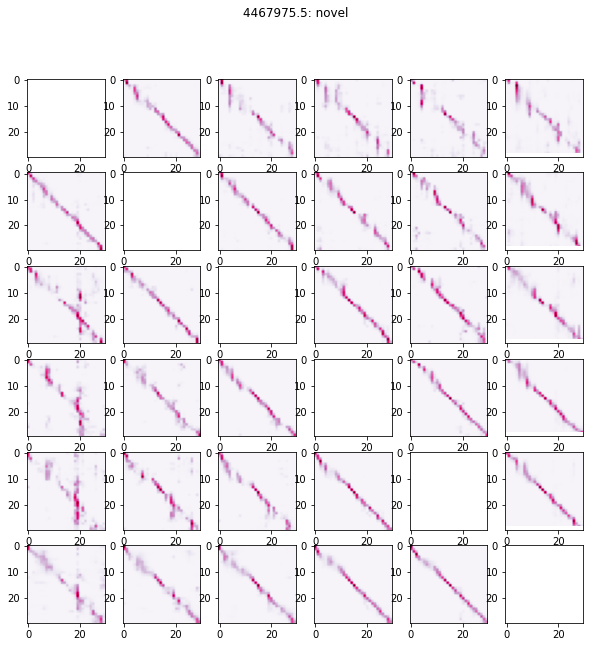

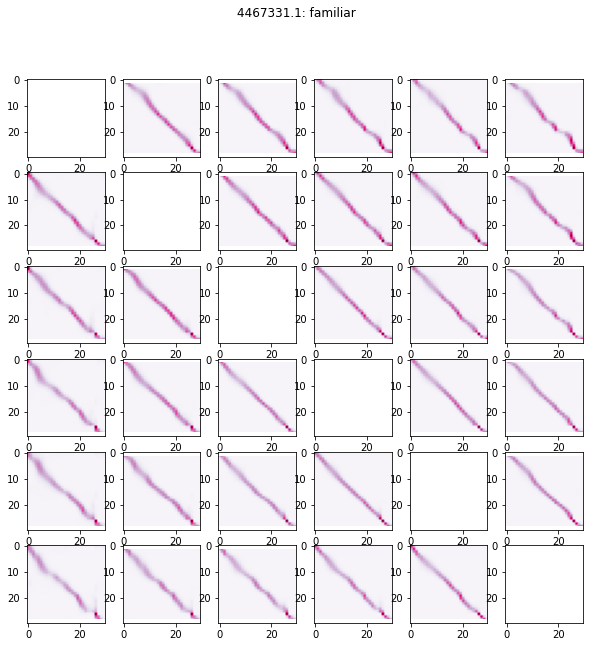

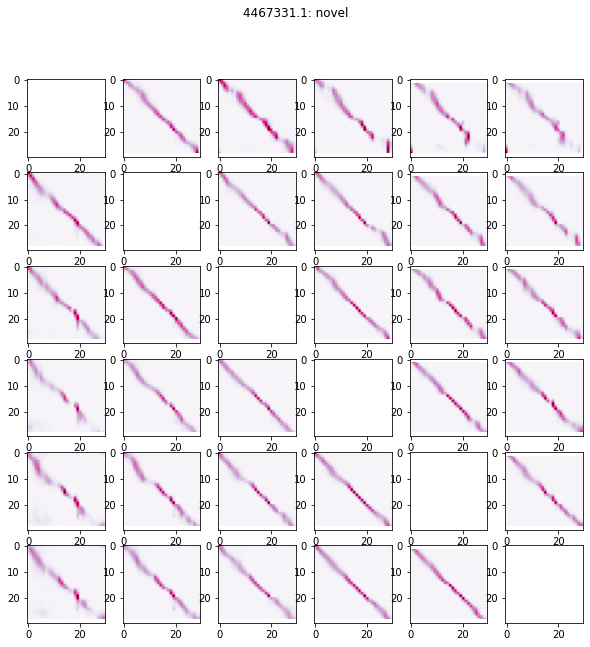

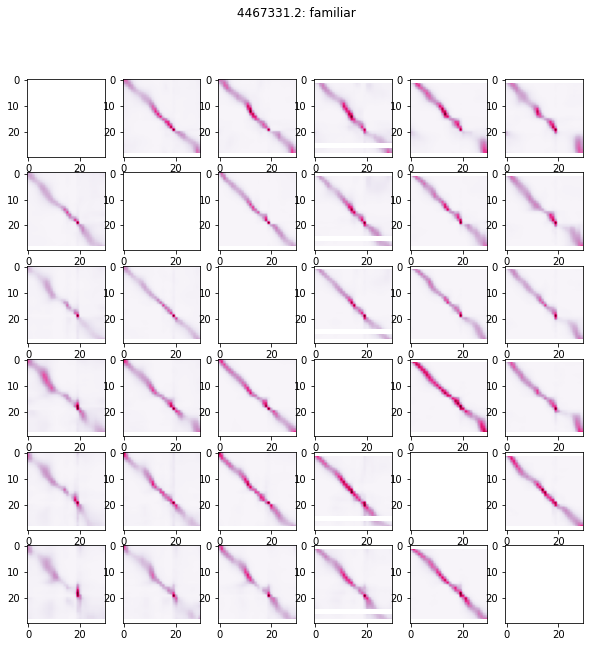

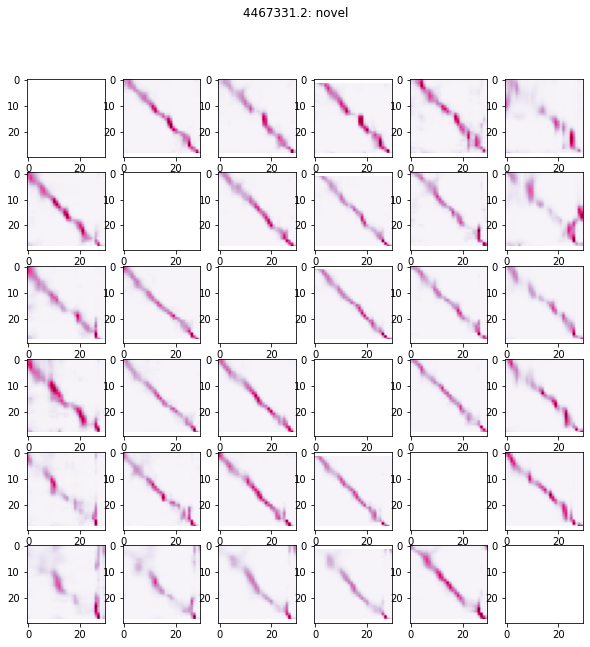

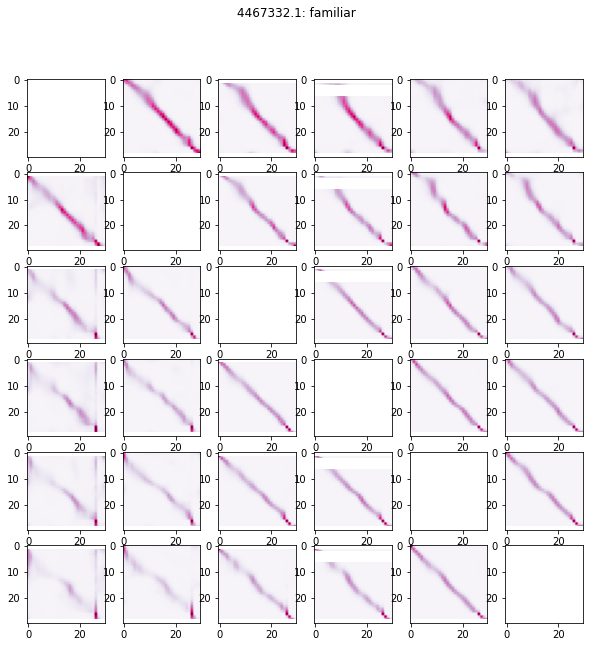

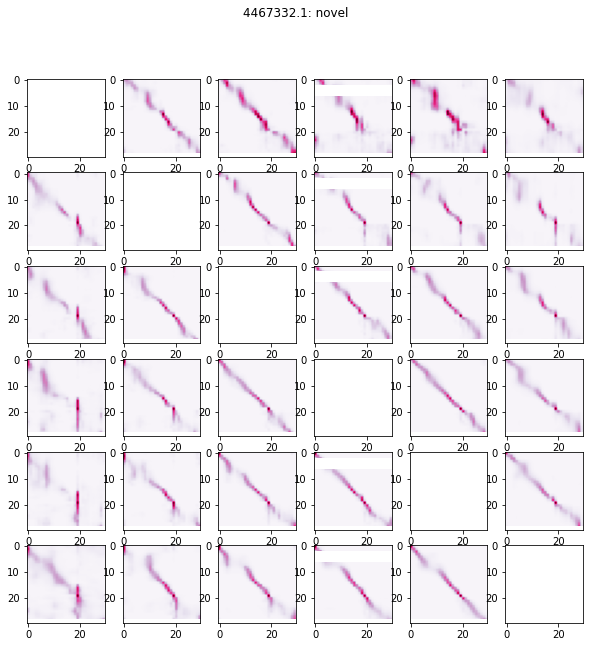

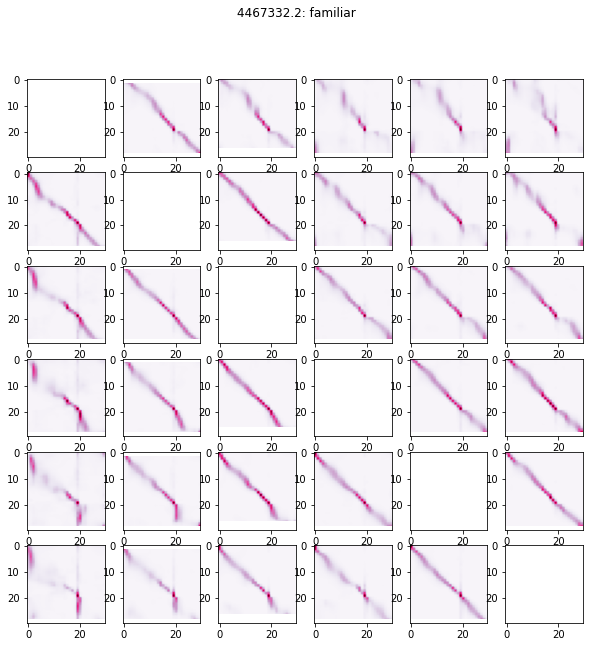

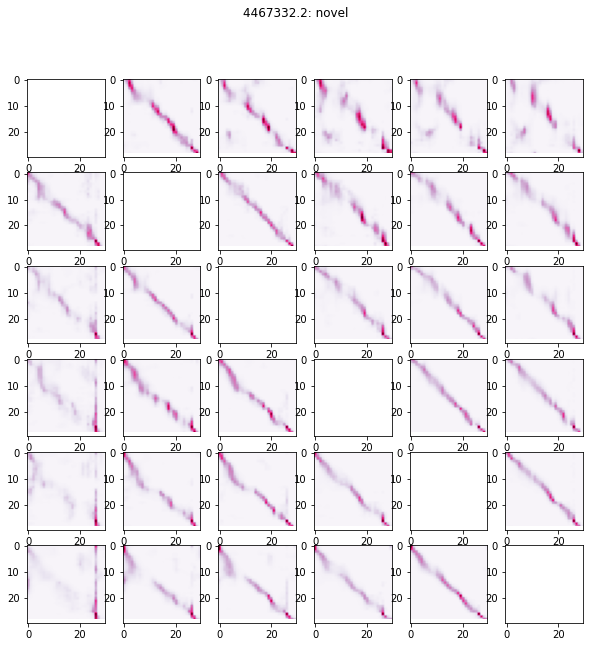

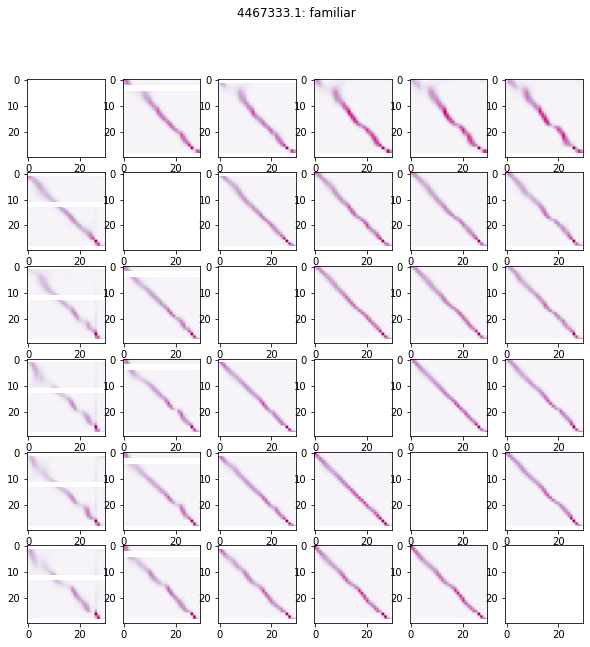

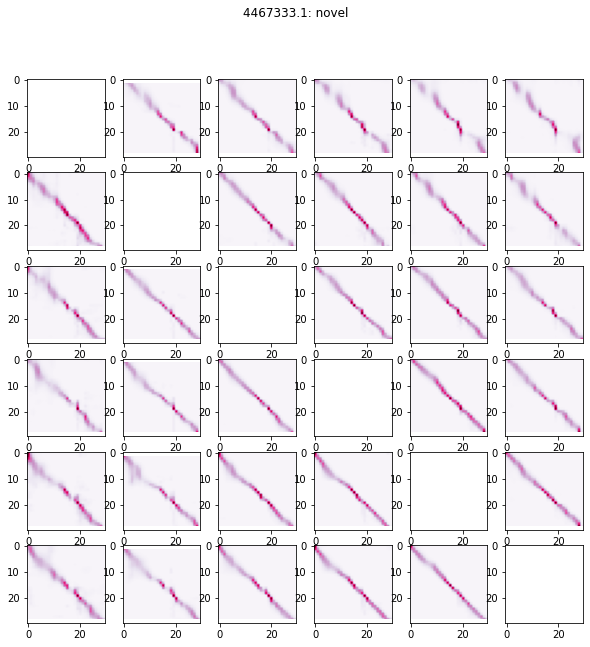

In [40]:

def plot_multiday_onemouse(mouse, results):
    
    fam_train, nov_train, sess_num, nov_trials, fam_trials = results['fam_train'], results['nov_train'], results['sess_num'], results['novel_trials'], results['fam_trials']
    
    days = [i for i in range(fam_train.shape[0])]
    fig,ax = plt.subplots(fam_train.shape[0],fam_train.shape[0],figsize=[10,10])
    for train_day in days:
        _fam_train = fam_train[train_day,:,:,:]
        for test_day in days:
            ax[train_day, test_day].imshow(_fam_train[(sess_num==test_day)*fam_trials,:,:].mean(axis=0),cmap='PuRd')
            
    fig.suptitle("%s: familiar" % mouse)
            
    fig2,ax2 = plt.subplots(fam_train.shape[0],fam_train.shape[0],figsize=[10,10])
    for train_day in days:
        _nov_train = nov_train[train_day,:,:,:]
        for test_day in days:
            ax2[train_day, test_day].imshow(_nov_train[(sess_num==test_day)*nov_trials,:,:].mean(axis=0),cmap='PuRd')
            
    fig2.suptitle("%s: novel" % mouse)
    

for mouse, res in ko_multiday_results.items():
    plot_multiday_onemouse(mouse,res)
    
for mouse, res in ctrl_multiday_results.items():
    plot_multiday_onemouse(mouse,res)

<ipython-input-52-99f4e44bb61b>:15: RuntimeWarning: Mean of empty slice
  fam_avg[m,train_day, test_day, :, :] = np.nanmean(_fam_train[(sess_num==test_day)*fam_trials,: ,:],axis=0)
<ipython-input-52-99f4e44bb61b>:16: RuntimeWarning: Mean of empty slice
  nov_avg[m,train_day, test_day, :, :] = np.nanmean(_nov_train[(sess_num==test_day)*nov_trials,: ,:],axis=0)
<ipython-input-52-99f4e44bb61b>:15: RuntimeWarning: Mean of empty slice
  fam_avg[m,train_day, test_day, :, :] = np.nanmean(_fam_train[(sess_num==test_day)*fam_trials,: ,:],axis=0)
<ipython-input-52-99f4e44bb61b>:16: RuntimeWarning: Mean of empty slice
  nov_avg[m,train_day, test_day, :, :] = np.nanmean(_nov_train[(sess_num==test_day)*nov_trials,: ,:],axis=0)


0 1 4
0 2 10
0 3 13
0 4 5
0 5 1
1 0 1
1 2 0
1 3 0
1 4 0
1 5 1
2 0 12
2 1 1
2 3 1
2 4 2
2 5 3
3 0 5
3 1 2
3 2 0
3 4 4
3 5 1
4 0 6
4 1 1
4 2 2
4 3 1
4 5 1
5 0 2
5 1 0
5 2 0
5 3 1
5 4 0


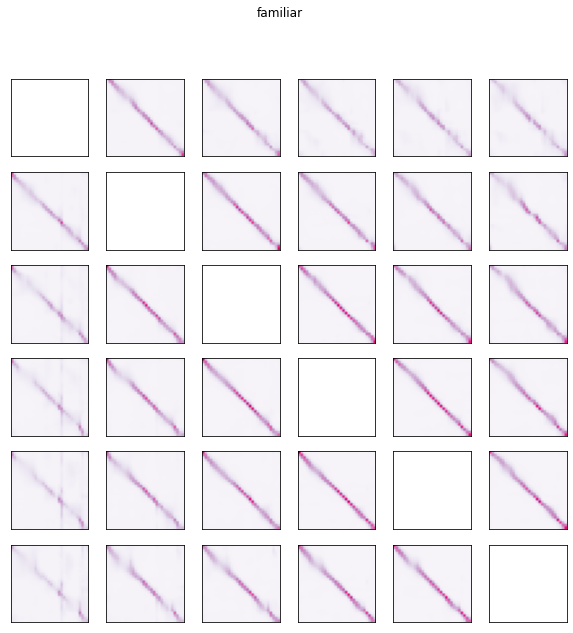

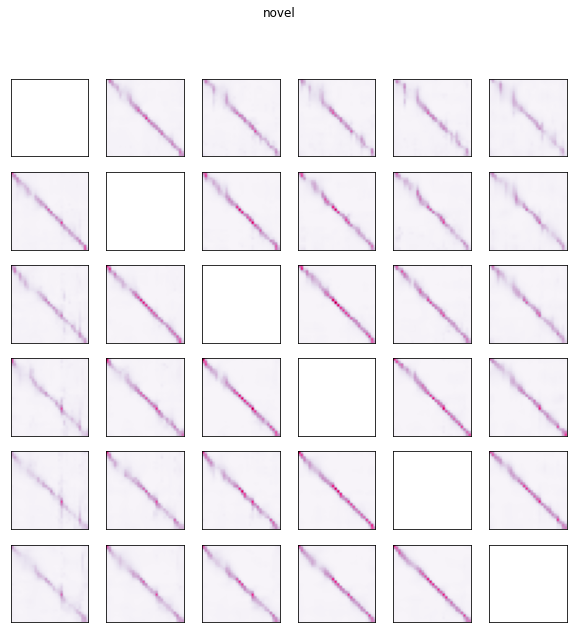

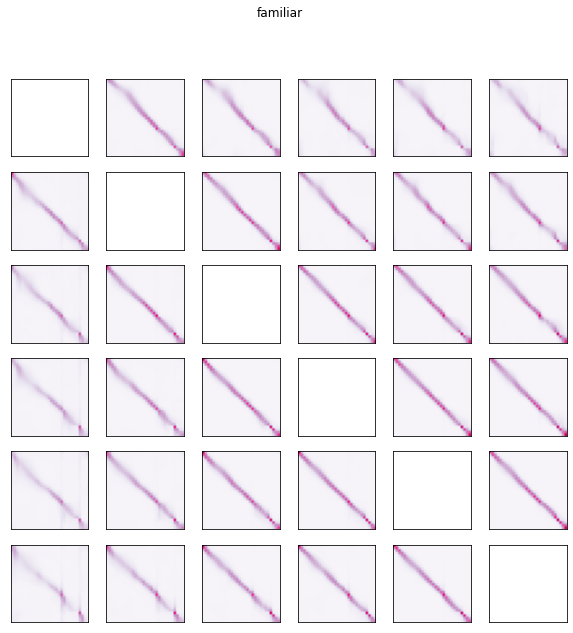

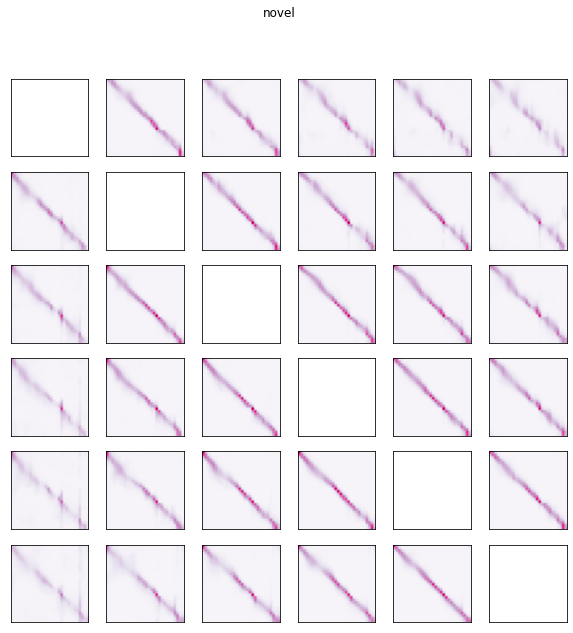

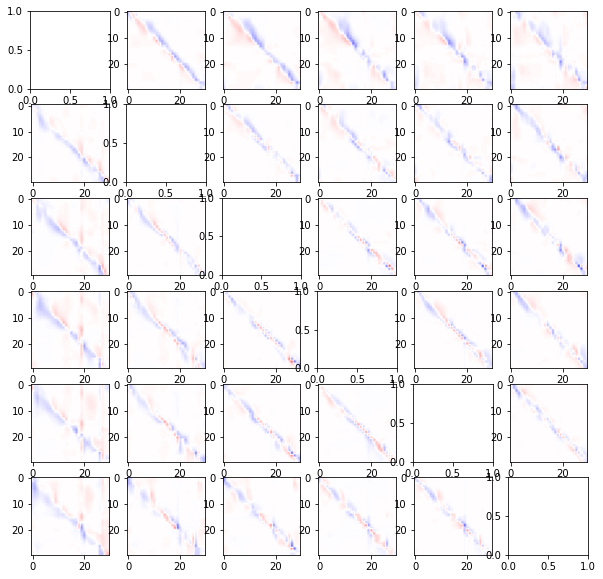

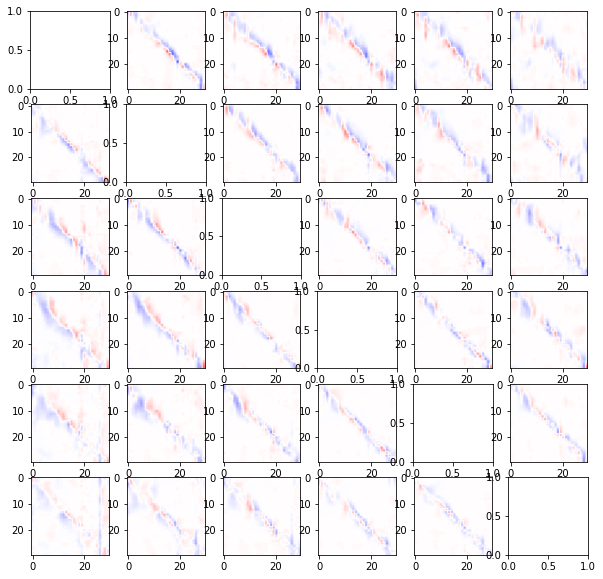

In [52]:
def plot_multiday_mouse_avg(results):
    
    
    fam_avg = np.zeros((5,6,6,30,30))
    nov_avg = np.zeros((5,6,6,30,30))
    for m, (mouse, res) in enumerate(results.items()):
        fam_train, nov_train, sess_num, nov_trials, fam_trials = res['fam_train'], res['nov_train'], res['sess_num'], res['novel_trials'], res['fam_trials']
    
        days = [j for j in range(fam_train.shape[0])]
        
        for train_day in days:
            _fam_train = fam_train[train_day,:,:,:]
            _nov_train = nov_train[train_day,:, :, :]
            for test_day in days:
                fam_avg[m,train_day, test_day, :, :] = np.nanmean(_fam_train[(sess_num==test_day)*fam_trials,: ,:],axis=0)
                nov_avg[m,train_day, test_day, :, :] = np.nanmean(_nov_train[(sess_num==test_day)*nov_trials,: ,:],axis=0)

#     fam_avg/=i+1
#     nov_avg/=i+1
    fig,ax = plt.subplots(6, 6, figsize=[10,10])
    fig2,ax2 = plt.subplots(6, 6, figsize=[10,10])
    for train_day in days:
        _fam_train = fam_train[train_day,:,:,:]
        for test_day in days:
            ax[train_day,test_day].imshow(fam_avg[:,train_day,test_day,:,:].mean(axis=0),cmap='PuRd',vmin=0,vmax=.8)
            ax[train_day,test_day].set_xticks([])
            ax[train_day,test_day].set_yticks([])
            ax2[train_day,test_day].imshow(nov_avg[:,train_day,test_day,:,:].mean(axis=0),cmap='PuRd',vmin=0,vmax=.8)
            ax2[train_day,test_day].set_xticks([])
            ax2[train_day,test_day].set_yticks([])
    fig.suptitle('familiar')
    fig2.suptitle('novel')
    return fam_avg, nov_avg, fig, fig2

ko_fam_avg, ko_nov_avg, ko_fig, ko_fig2 = plot_multiday_mouse_avg(ko_multiday_results)
ko_fig.savefig(os.path.join(figdir,"ko_fam_across_day_decoding.pdf"))
ko_fig2.savefig(os.path.join(figdir,"ko_nov_across_day_decoding.pdf"))
ctrl_fam_avg, ctrl_nov_avg, ctrl_fig, ctrl_fig2 = plot_multiday_mouse_avg(ctrl_multiday_results)
ctrl_fig.savefig(os.path.join(figdir,"ctrl_fam_across_day_decoding.pdf"))
ctrl_fig2.savefig(os.path.join(figdir,"ctrl_nov_across_day_decoding.pdf"))

diff_fam_avg = (ko_fam_avg.mean(axis=0)-ctrl_fam_avg.mean(axis=0))#/(ko_fam_avg.var(axis=0) + ctrl_fam_avg.var(axis=0))**.5

diff_nov_avg = (ko_nov_avg.mean(axis=0)-ctrl_nov_avg.mean(axis=0))#/(ko_nov_avg.var(axis=0) + ctrl_nov_avg.var(axis=0))**.5
days = [i for i in range(6)]
fig,ax = plt.subplots(6,6,figsize=[10,10])
fig2,ax2 = plt.subplots(6,6,figsize=[10,10])
for train_day in days:
    for test_day in days:
        if train_day !=test_day:
#             print(diff_fam_avg[train_day,test_day,:,:])
            t,p = sp.stats.ttest_ind(ko_fam_avg[:,train_day,test_day,:,:], ctrl_fam_avg[:,train_day,test_day,:,:],axis=0)
            print(train_day, test_day, (p<.01).sum())
            ax[train_day,test_day].imshow(diff_fam_avg[train_day,test_day,:,:],cmap='seismic',vmin=-1,vmax=1)
            ax2[train_day,test_day].imshow(diff_nov_avg[train_day,test_day,:,:],cmap='seismic',vmin=-1,vmax=1)
fig.savefig(os.path.join(figdir,"fam_across_day_decoding_diff.pdf"))
fig2.savefig(os.path.join(figdir,"nov_across_day_decoding_diff.pdf"))

                
    

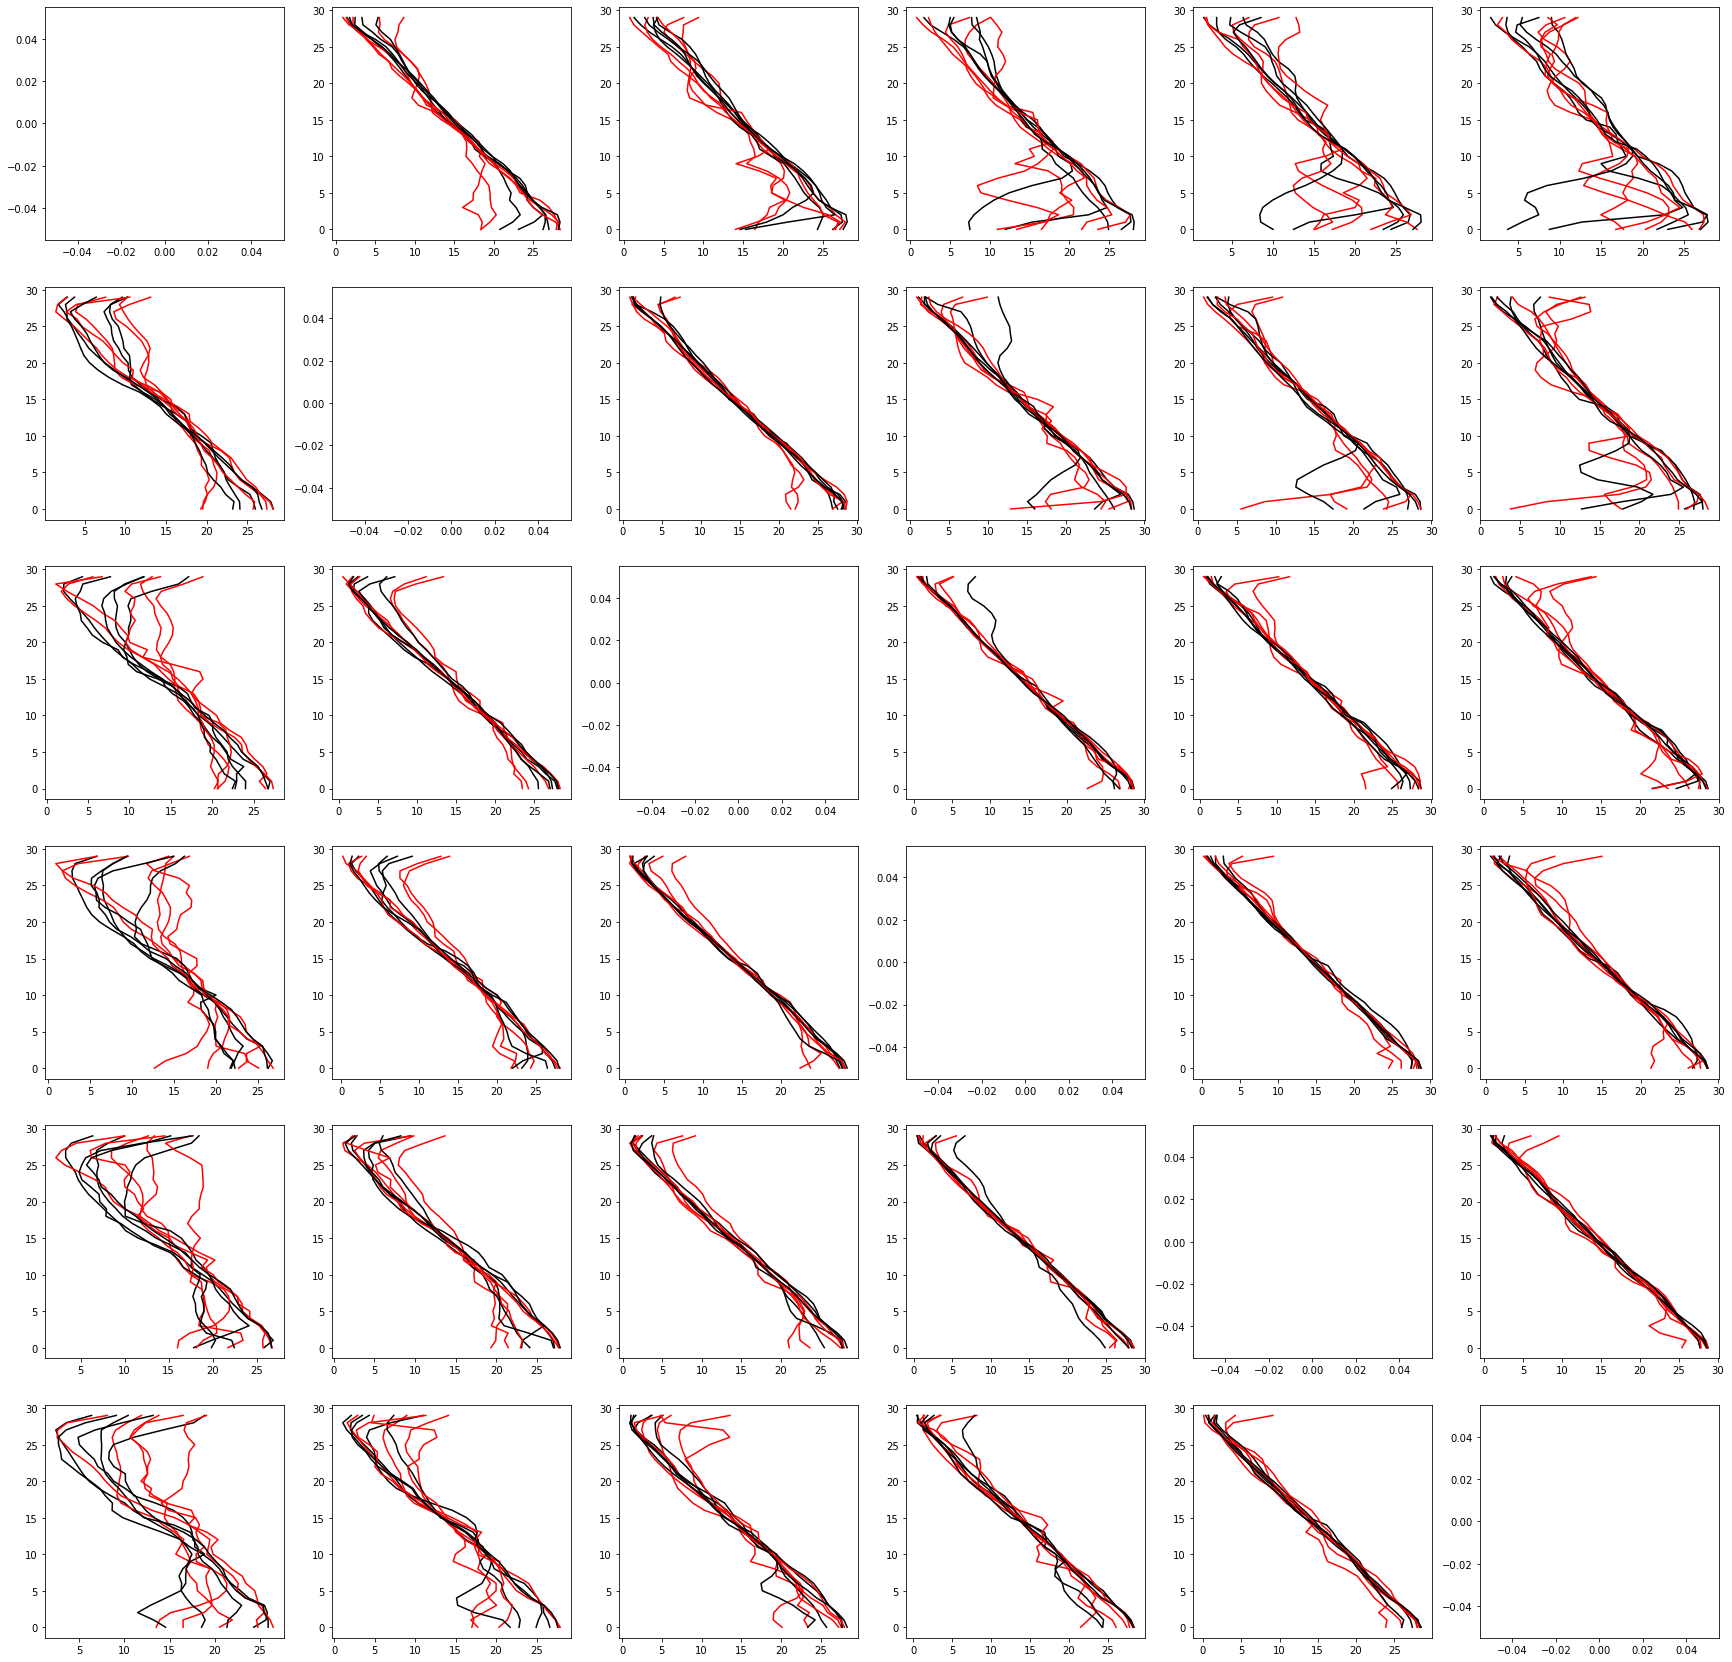

In [50]:
fig,ax = plt.subplots(6, 6, figsize=[30,30])
for m in range(5):
    for train_day in range(6):
        for test_day in range(6):
#             ax[train_day,test_day].plot(np.argmax(ko_fam_avg[m,train_day,test_day,:,:],axis=-1),np.arange(0,30)[::-1],color='red')
            ax[train_day,test_day].plot([sp.ndimage.center_of_mass(ko_fam_avg[m,train_day,test_day,i,:]) for i in range(30)],np.arange(0,30)[::-1],color='red')
            ax[train_day,test_day].plot([sp.ndimage.center_of_mass(ctrl_fam_avg[m,train_day,test_day,i,:]) for i in range(30)],np.arange(0,30)[::-1],color='black')
#             ax[train_day,test_day].plot(np.argmax(ctrl_fam_avg[m,train_day,test_day,:,:],axis=-1),np.arange(0,30)[::-1],color='black')
            
# print(ko_fam_max.shape)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


28_09_2020 YMaze_LNovel
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
LR
block_number
sess_num_ravel
sess_num
32.67690445738824
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
LR
block_number
sess_num_ravel
sess_num
39.83365218636522
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
LR
block_number
sess_num_ravel
sess_num
32.67690445738824
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_0

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


05_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
LR
block_number
sess_num_ravel
sess_num
32.67690445738824


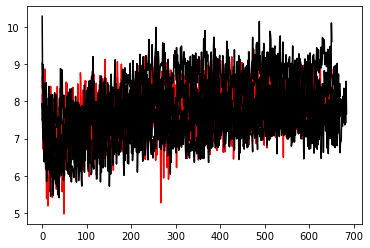

In [68]:
# corroborate with just looking at cell shifts
fig, ax = plt.subplots()


for mouse in stx.ymaze_sess_deets.KO_sessions.keys():
    concat_sess = single_mouse_concat_sessions(mouse,date_inds=[i for i in range(6)])
    
    spks = np.copy(concat_sess.trial_matrices['spks'])
    spks[np.isnan(spks)]=1E-3
    spks = sp.ndimage.filters.gaussian_filter1d(spks,1,axis=1)
#     com = (spks*np.arange(0,30)[np.newaxis,:,np.newaxis]).sum(axis=1)/spks.sum(axis=1)
    com = np.argmax(spks,axis=1)
    fam_trials = concat_sess.trial_info['LR']==-1*concat_sess.novel_arm
    
    if concat_sess.novel_arm == 1:
        rzone = concat_sess.rzone_late['tfront']
    else:
        rzone = concat_sess.rzone_early['tfront']
    print(rzone)
    
    _com = com[fam_trials,:]
    baseline = _com[:50,:].mean(axis=0,keepdims=True)
    ax.plot(np.abs(_com-baseline).mean(axis=-1).ravel(),color='red')
    
for mouse in stx.ymaze_sess_deets.CTRL_sessions.keys():
    concat_sess = single_mouse_concat_sessions(mouse,date_inds=[i for i in range(6)])
    
    spks = np.copy(concat_sess.trial_matrices['spks'])
    spks[np.isnan(spks)]=1E-3
    spks = sp.ndimage.filters.gaussian_filter1d(spks,1,axis=1)
#     com = (spks*np.arange(0,30)[np.newaxis,:,np.newaxis]).sum(axis=1)/spks.sum(axis=1)
    com = np.argmax(spks,axis=1)
    fam_trials = concat_sess.trial_info['LR']==-1*concat_sess.novel_arm
    
    if concat_sess.novel_arm == 1:
        rzone = concat_sess.rzone_late['tfront']
    else:
        rzone = concat_sess.rzone_early['tfront']
    print(rzone)
    
    _com = com[fam_trials,:]
    baseline = _com[:50,:].mean(axis=0,keepdims=True)
    ax.plot(np.abs(_com-baseline).mean(axis=-1).ravel(),color='black')



# reward reversal 

In [ ]:
# train on baseline  day 6

# train on last block from day 7